# PHYS 141 Final Project
Final Project for PHYS 141 at UCSD, Spring 2025

Taught by Professor Hongbo Zhao

Project by Christian O'Connor

Gemini Pro 2.5 was used for some code generation.

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial

# Lagrangian Neural Networks with Spring Pendulum

Lagrangian Neural Networks (LNNs) are a special kind of multilayer perceptron that utilizes the Euler-Lagrange relationship to find accurate models of dynamics from a set of data, with an emphasis on energy conservation.

This notebook, heavily inspired by [Sam Greydanus' work](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq), will model a spring/elastic pendulum using analytical methods, generate data using that model, and train an LNN model to attempt to accurately model an elastic pendulum's rollout. I will also compare the results with that of a standard, "naïve", multilayer perceptron (MLP) model.

Here are teasers of some of the coolest graphs you can expect to generate in this Notebook:

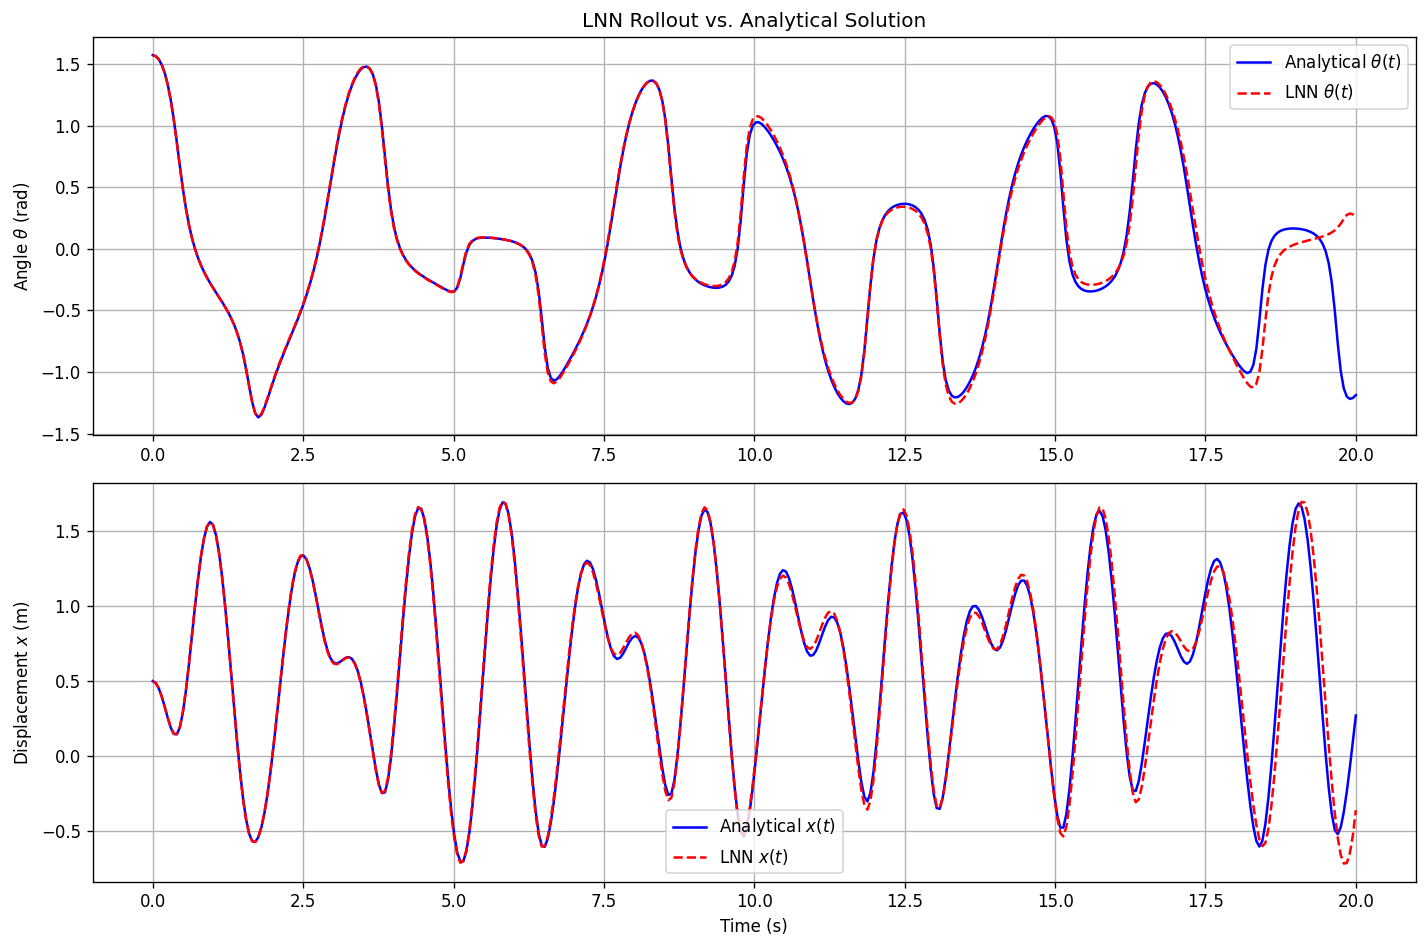

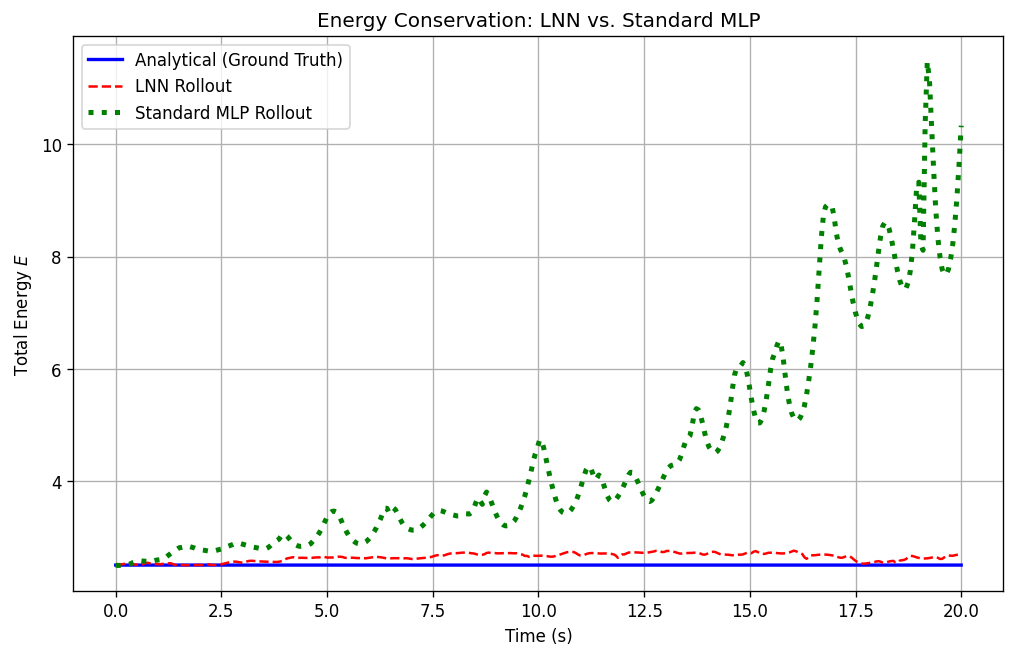

Interested? Great! Let's get started by analytically finding the Lagrangian of an elastic pendulum system to base our learned Lagrangian off of.

## Model the Spring Pendulum

A Lagrangian is in the form:
$$L=T-V$$
Where:
*   $T$ is the kinetic energy of the system
*   $V$ is the potential energy of the system.

The Lagrangian will be a function expressed in the form $L(q,\dot{q})$ where $q$ is the coordinate system. In this case, we can take the coordinates $(\theta, x)$ where $\theta$ is the angle of the pendulum from the vertical and $x$ is the displacement from the equilibrium length of the spring.

### Kinetic Energy

The kinetic energy is given by the sum of the rotational and translational kinetic energy:
$$T=K_r+K_t$$
Where:
$$\begin{align*}
K_r&= \frac{1}{2} I\omega^2\\
K_t&= \frac{1}{2} mv^2
\end{align*}$$

We need to express this in terms of our coordinates $(\theta, x)$.

**Rotational Kinetic Energy**

Let's first do this for the rotational kinetic energy $K_r$. The moment of inertia $I$ is expressed by $I= mr^2$ where $m$ is the mass of the object and $r$ is the position in reference to the hinge of the object. In our case, since all the mass is at the very end of the spring (considering the spring to be massless), we can write the moment of inertia as:
$$I=m(l+x)^2$$
Consider the angular velocity $\omega$ to be the derivative of the angle $\theta$, so we have the rotational kinetic energy defined by:
$$K_r= \frac{1}{2} m(l+x)^2\dot{\theta}^2$$
Where:
*   $m$ is the mass of the object
*   $l$ is the equilibrium length of the spring
*   $x$ is the displacement of the spring (at a given time)
*   $\theta$ is the angle of the pendulum from the vertical (at a given time).
Since we have all constants other than $(\theta, x)$ and their derivatives, this is in terms of our coordinates.


**Translational Kinetic Energy**

Next, we can express $K_t$ in terms of $(\theta,x)$:
$$K_t=\frac{1}{2} m\dot{x}^2$$
Where:
*   $m$ is the mass of the object
*   $x$ is the displacement of the spring (at a given time).

Since we have all constants other than $(\theta, x)$ and their derivatives, this is in terms of our coordinates.

**Total Kinetic Energy**

So, combining these components of kinetic energy, we can derive the total kinetic energy $T$:
$$\begin{align*}
T&= K_r+K_t\\
&= \frac{1}{2} m(l+x)^2\dot{\theta}^2 + \frac{1}{2} m\dot{x}^2\\
&= \frac{1}{2}m\left(\dot{x}^2+(l+x)^2\dot{\theta}^2\right)
\end{align*}$$

### Potential Energy

Next, we must express the potential energy in terms of $(x,\theta)$. The following equation represents the total potential energy as a sum of the spring and gravitational energies:
$$V=V_k+V_g$$
Where:
$$\begin{align*}
V_k &= \frac{1}{2}kx^2\\
V_g &= -mgh
\end{align*}$$
>Note that $V_g$ is considered negative since it is working against the motion of the system.

**Spring Potential Energy**

$V_k$ is represented as follows:
$$V_k=\frac{1}{2}kx^2$$
Where:
*   $k$ is the spring constant
*   $x$ is the displacement from equilibrium of the spring.

This is already in terms of $(\theta, x)$, so no changes are necessary.

**Gravitational Potential Energy**

$V_g$ is represented as follows:
$$V_g = -mgh$$
Where:
*   $m$ is the mass of the object on the spring
*   $g$ is the gravitational acceleration
*   $h$ is the "height" of the object, or vertical displacement from a defined initial position.

The issue here is $h$. Let's consider the initial "zero" position to be the level of the hinge. This means we can write the height as $h=(l+x)\cos\theta$, or the vertical displacement of the object at a displacement $x$ and angle $\theta$ from the hinge's height:

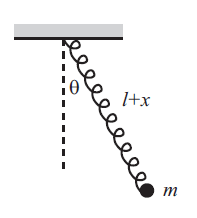

Thus, $V_g$ can be written as:
$$V_g=-mg(l+x)\cos\theta$$

**Total Potential Energy**
Finally, combine these to get the total potential energy $V$:
$$\begin{align*}
V&= V_k + V_g\\
&= \frac{1}{2}kx^2 -mg(l+x)\cos\theta
\end{align*}$$
>Since these are all constants except for $x$ and $\theta$, we have successfully expressed $V_g$ in terms of $(\theta, x)$.

### Analytical Lagrangian
Using these energies in terms of the coordinates $(\theta, x)$, we can write the lagrangian as follows:
$$\begin{align*}L\left[\theta,x,\dot\theta,\dot{x}\right]&= T-V\\
&= \frac{1}{2}m\left(\dot{x}^2+(l+x)^2\dot{\theta}^2\right) - \left(
\frac{1}{2}kx^2 -mg(l+x)\cos\theta\right)
\end{align*}$$

To begin implementing this in Python, we can use this to define our analytical Lagrangian as the following function:

In [ ]:
def analytical_lagrangian(q, q_t, m=1, l=1, g=9.8, k=1):
  theta, x = q
  theta_t, x_t = q_t

  T = 0.5 * m * (x_t**2 + (l + x)**2 * theta_t**2)
  V = 0.5 * k * x**2 - m * g * (l + x) * jnp.cos(theta)

  return T - V

## Obtain Dynamics from Lagrangian
With the Lagrangian written, let's obtain the dynamics of the system from it. We will do this by writing the Euler-Lagrange relationship and then solving for $\ddot{q}$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

This method of retrieving the equation of motion involves some potentially non-trivial computations, but we can use JAX's automatic differentiation to make this run smoothly.

In [ ]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

This function takes in a Lagrangian and current state $(q,\dot{q})$ and returns the time derivates $(\dot{q}, \ddot{q})$. We can now use this to create a complete Lagrangian solver, which given a Lagrangian and initial state, will return the integrated equation of motion using `odeint`.

In [ ]:
def solve_lagrangian(lagrangian, initial_state, **kwargs):
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

To compare JAX's autograd results against, we will solve the Euler-Lagrange relationship for $\ddot{x}$ and $\ddot{\theta}$ (our two degrees of freedom):

$$\begin{align*}
\frac{\partial L}{\partial x} - \frac{d}{dt}\frac{\partial L}{\partial \dot{x}}&= 0\\
\frac{\partial L}{\partial \theta} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}}&= 0
\end{align*}$$

In terms of $x$:
$$m(l+x)\dot{\theta}^2-kx+mg\cos\theta-m\ddot{x}=0$$

And solving for $\ddot{x}$:
$$\ddot{x}= (l+x)\dot{\theta}^2 - \frac{k}{m}x+g\cos\theta$$

And in terms of $\theta$:
$$-mg(l+x)\sin\theta-m(l+x)^2\ddot{\theta}-2m(l+x)\dot{x}\dot{\theta}=0$$

And solving for $\ddot{\theta}$:
$$\ddot{\theta}= -\frac{g}{l+x}\sin\theta-\frac{2\dot{x}}{l+x}\dot{\theta}$$

Let's use this system of equations to implement the `f_analytical` function that takes in the current state $(q,\dot{q})$ and returns $(\dot{q}, \ddot{q})$:

In [ ]:
def f_analytical(state, t=0, m=1, l=1, g=9.8, k=1):
  theta, x, theta_t, x_t = state
  theta_tt = -g / (l + x) * jnp.sin(theta) - 2 * x_t / (l + x) * theta_t
  x_tt = (l + x) * theta_t**2 - (k / m) * x + g * jnp.cos(theta)
  return jnp.stack([theta_t, x_t, theta_tt, x_tt])

### Helper Functions
The following helper functions will help us implement this spring pendulum system:

In [ ]:
# Spring pendulum dynamics via the rewritten Euler-Lagrange and autograd
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m=1, l=1, g=9.8, k=1):
  L = partial(analytical_lagrangian, m=m, l=l, g=g, k=k)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Elastic pendulum dynamics via analytical solution for equations of motion
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times, m=1, l=1, g=9.8, k=1):
  f = partial(f_analytical, m=m, l=l, g=g, k=k)
  return odeint(f, initial_state, times, rtol=1e-10, atol=1e-10)

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

### Compare Analytical vs. Autograd Solutions

So, we have `solve_autograd` which uses JAX's automatic differentiation function (`jax.grad`), as well as `solve_analytical` which uses JAX's `odeint` function, which is the analogue to `solve_ivp` from SciPy which we have used previously in this class.

The following steps will compare the basic analytical solution (using `odeint`) against the automatic differentiation (using `jax.autograd`) to see what kind of error we can expect from this rather than the LNN error.

In [ ]:
# Set initial state
x0 = np.array([np.pi * 0.8, 0.0, 0.0, 0.0], dtype=np.float32) # x0 = (q, q_t)
m_val = 1.0
l_val = 1.0
g_val = 9.8
k_val = 10.0
t = np.linspace(0, 200, num=2001, dtype=np.float32)

In [ ]:
# compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t, m=m_val, l=l_val, g=g_val, k=k_val))

CPU times: user 1.12 s, sys: 98.3 ms, total: 1.22 s
Wall time: 2.15 s


In [ ]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t, m=m_val, l=l_val, g=g_val, k=k_val))

CPU times: user 2.97 s, sys: 203 ms, total: 3.17 s
Wall time: 2.83 s


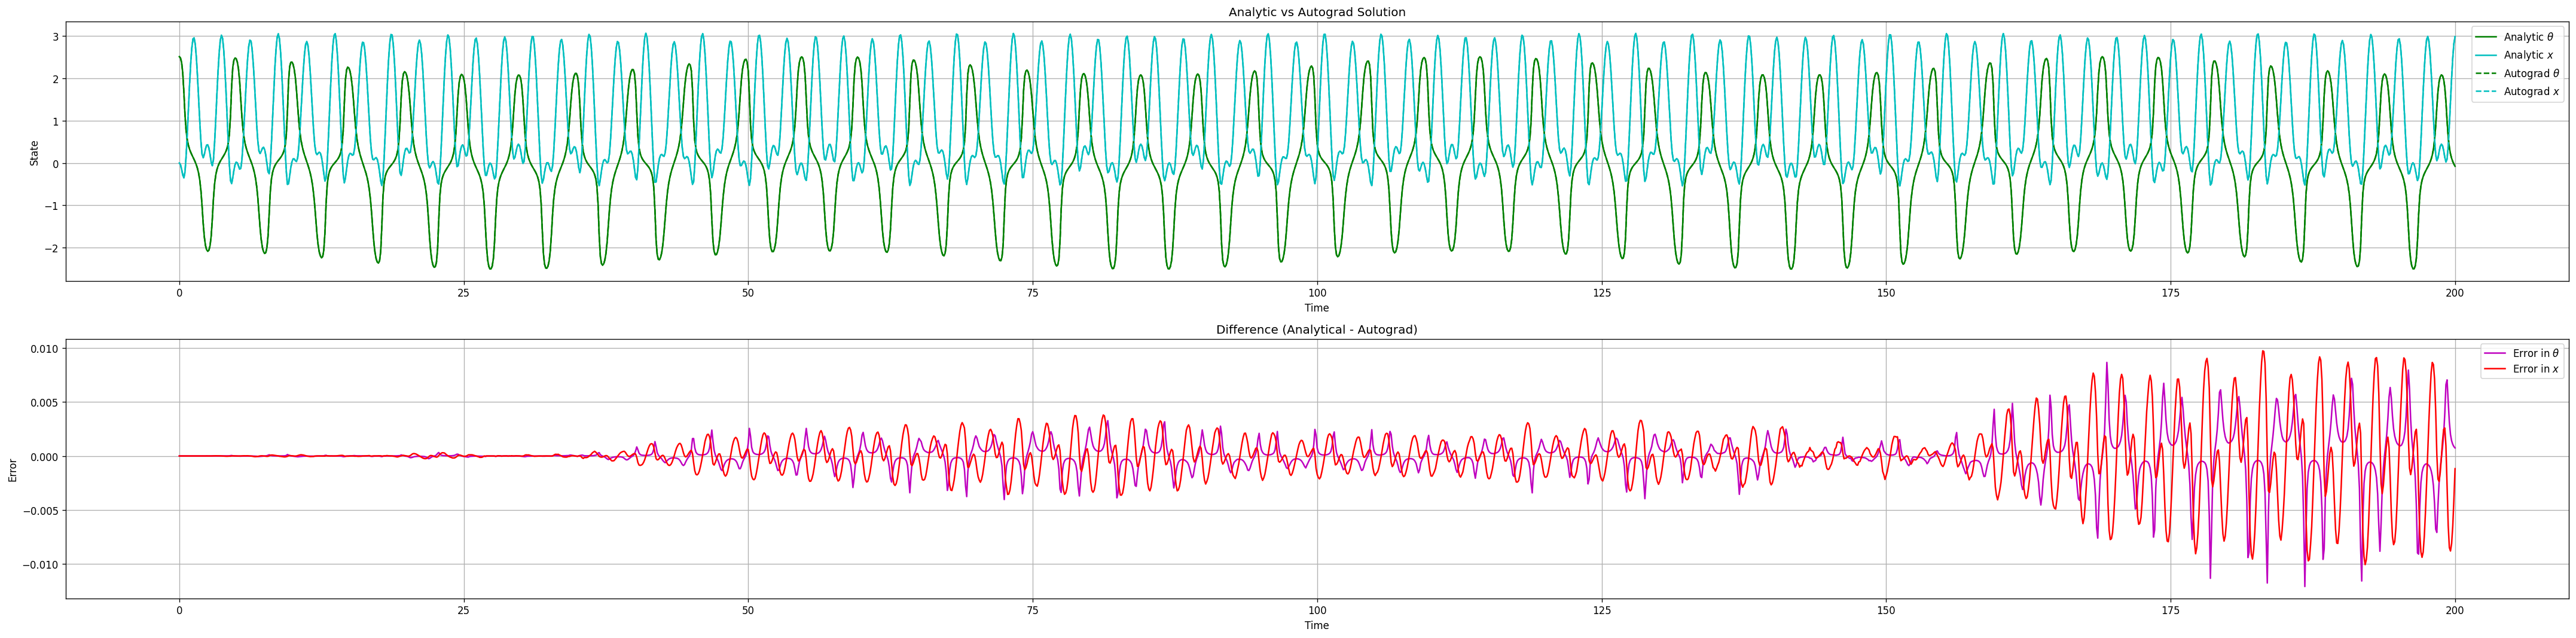

In [ ]:
plt.figure(figsize=[36, 9], dpi=120) # Adjusted figure size

# --- Plot 1: Analytic vs Autograd ---
plt.subplot(2, 1, 1) # Changed to a 2x1 layout for clarity
plt.title("Analytic vs Autograd Solution")
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label=r'Analytic $\theta$')
plt.plot(t, x_analytical[:, 1], 'c-', label=r'Analytic $x$')
plt.plot(t, x_autograd[:, 0], 'g--', label=r'Autograd $\theta$')
plt.plot(t, x_autograd[:, 1], 'c--', label=r'Autograd $x$')
plt.legend()
plt.grid(True)

# --- Plot 2: Difference between solutions ---
# This is the new plot you requested.
plt.subplot(2, 1, 2)
# Calculate the difference (error)
difference = x_analytical - x_autograd
plt.title("Difference (Analytical - Autograd)")
plt.xlabel("Time")
plt.ylabel("Error")
# Plot the difference for the first state variable (theta)
plt.plot(t, difference[:, 0], 'm-', label=r'Error in $\theta$')
# Plot the difference for the second state variable (x)
plt.plot(t, difference[:, 1], 'r-', label=r'Error in $x$')
plt.legend()
plt.grid(True)

plt.tight_layout() ; plt.show()

These graphs tell us the `jax.grad` function is quite accurate, especially for this system. Even after a relatively long rollout of 2001 time steps, they remain pretty consistent, as seen in the top graph. I added the bottom plot to show the difference over time, and you can see it does reach a maximum difference of about $\pm 0.010$, steadily increasing over time as expected. This is relatively neglible, as seen in the top graph, and especially when observing shorter time scales than this.

This implies the error caused by `jax.grad` will be miniscule, so we can reliably use our `solve_lagrangian` function to compare our LNN's learned Lagrangian.

To better visualize their similarities, we can use `matplotlib` to create an animation of this data as follows. This animation style will also be used in the future for visualizing rollouts, so be sure to run the following `import` cell:

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

Note the animation may take a few minutes to load, not due to computation of the actual rollout, but just for the animation.

In [ ]:
# Choose parameters and initial state
m_val = 1.0
l_val = 1.0
g_val = 9.8
k_val = 9.8
x0 = np.array([np.pi * 0.8, 1.0, 2.0, 1.0], dtype=np.float32) # Higher energy initial state

# Time span for the simulation
t = np.linspace(0, 20, num=400, dtype=np.float32)

# Compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t, m=m_val, l=l_val, g=g_val, k=k_val))

# Compute dynamics using autograd
%time x_autograd = jax.device_get(solve_autograd(x0, t, m=m_val, l=l_val, g=g_val, k=k_val))

# --- Animation Code ---
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Function to get Cartesian coordinates from state (theta, x)
def get_cartesian_coords(state, l):
    theta, x = state[0], state[1]
    r = l + x # Total length of the spring
    # Origin is at (0, 0)
    y = -r * jnp.cos(theta) # y-coordinate (down is positive in physics conventions, but let's use down as negative for plotting)
    x_coord = r * jnp.sin(theta) # x-coordinate
    return x_coord, y

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 8)) # Slightly larger figure for more lines
ax.set_xlim(-(l_val + jnp.max(jnp.abs(x_analytical[:, 1])) + 0.5), (l_val + jnp.max(jnp.abs(x_analytical[:, 1])) + 0.5)) # Adjust limits based on maximum extension
ax.set_ylim(-(l_val + jnp.max(jnp.abs(x_analytical[:, 1])) + 0.5), (l_val + jnp.max(jnp.abs(x_analytical[:, 1])) + 0.5))
ax.set_aspect('equal', adjustable='box')
ax.set_title("Spring Pendulum Simulations Overlay") # More descriptive title
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)

# Draw the pivot point
ax.plot(0, 0, 'ko', markersize=5, zorder=5) # Black circle for pivot, zorder to ensure it's on top

# Initialize the line and point for the analytical simulation
line_analytical, = ax.plot([], [], 'b-', lw=2, label='Analytical') # Blue line for spring
mass_analytical, = ax.plot([], [], 'bo', markersize=8) # Blue circle for mass

# Initialize the line and point for the autograd simulation
line_autograd, = ax.plot([], [], 'r--', lw=1, label='Autograd') # Red dashed line for spring
mass_autograd, = ax.plot([], [], 'ro', markersize=5) # Red circle for mass

ax.legend(loc='upper right') # Add legend to identify the simulations

# Function to initialize the animation
def init():
    line_analytical.set_data([], [])
    mass_analytical.set_data([], [])
    line_autograd.set_data([], [])
    mass_autograd.set_data([], [])
    # Return all artists that will be updated
    return (line_analytical, mass_analytical,
            line_autograd, mass_autograd)

# Function to update the plot for each frame
def animate(i):
    # Analytical state at time step i
    state_analytical_i = x_analytical[i, :]
    x_an, y_an = get_cartesian_coords(state_analytical_i, l_val)
    line_analytical.set_data([0, x_an], [0, y_an])
    mass_analytical.set_data([x_an], [y_an])

    # Autograd state at time step i
    state_autograd_i = x_autograd[i, :]
    x_auto, y_auto = get_cartesian_coords(state_autograd_i, l_val)
    line_autograd.set_data([0, x_auto], [0, y_auto])
    mass_autograd.set_data([x_auto], [y_auto])


    # Return all artists that were updated
    return (line_analytical, mass_analytical,
            line_autograd, mass_autograd)


# Create the animation
# interval = time between frames in milliseconds
# frames = number of frames (equal to the number of time steps)
# Use a higher fps (frames per second) for smoother animation if needed
ani = FuncAnimation(fig, animate, frames=len(t), init_func=init, blit=True, interval=t[1]*1000)

# Close the figure to prevent it from showing as a static plot
plt.close(fig)

display(HTML(ani.to_jshtml()))

From this animation, we can see that the analytical and autograd versions stay directly on top of each other the entire rollout.

Get used to this animation layout, it will return later on...

## Generate test data for LNN

Now, let's begin creating the actual Lagrangian Neural Network. We begin by generating test data using the analytical solution we programmed above (in `solve_analytical`). First, run the following `import` cell:

In [ ]:
import optax
import flax.linen as nn
from flax.training import train_state
from sklearn.preprocessing import StandardScaler

We will split into training and testing data, with all the data having an arbitrary initial condition of:
$$(\theta, x,\dot\theta,\dot{x})= \left(\frac{\pi}{2}, 0.5, 0.0, 0.0\right)$$

The data is generated over time `t_span` from $0$ to $50$, with a total of 5000 individual time steps, meaning each unit time has 1000 time steps. This data is then split in two, with the first 2500 time steps being reserved for training, and latter 2500 being reserved for testing.

In [ ]:
def normalize_state(state):
  """
  Normalizes the angle theta to the range [-pi, pi].
  The state vector is [theta, x, theta_dot, x_dot].
  """
  # Wrap the first element (theta) to [-pi, pi]
  wrapped_theta = (state[0] + jnp.pi) % (2 * jnp.pi) - jnp.pi
  # Return the new state with the wrapped angle
  return state.at[0].set(wrapped_theta)


# --- Data Generation Parameters ---
# System parameters
m_val = 1.0
l_val = 1.0
g_val = 9.8
k_val = 20.0 # A stiffer spring to see more oscillations

# Simulation parameters
t_span = np.linspace(0, 50, num=5000, dtype=np.float32)
x0 = np.array([np.pi * 0.5, 0.5, 0.0, 0.0], dtype=np.float32) # Initial state (theta, x, theta_dot, x_dot)

# --- Generate the Full Trajectory ---
# Create a partial function for the analytical solver with our chosen parameters
analytical_solver = partial(solve_analytical, m=m_val, l=l_val, g=g_val, k=k_val)
f_analytical_partial = partial(f_analytical, m=m_val, l=l_val, g=g_val, k=k_val)

# Generate the state trajectory (x)
print("Generating state trajectory...")
x_full = jax.device_get(analytical_solver(x0, t_span))

# Generate the state time derivatives (xt) using the analytical force function
# We use jax.vmap to efficiently apply the function over the whole trajectory
print("Generating derivative trajectory...")
xt_full = jax.device_get(jax.vmap(f_analytical_partial)(x_full))
print("Data generation complete.")


# --- Split into Training and Test Sets ---
split_index = len(t_span) // 2

# State data
x_train = x_full[:split_index]
x_test = x_full[split_index:]

# Derivative data (our training targets)
xt_train = xt_full[:split_index]
xt_test = xt_full[split_index:]

# --- Normalize the States ---
# Apply the state normalization to the training and test inputs
x_train = jax.vmap(normalize_state)(x_train)
x_test = jax.vmap(normalize_state)(x_test)


print(f"Total samples: {len(x_full)}")
print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"State vector shape: {x_train.shape}")
print(f"Derivative vector shape: {xt_train.shape}")

Generating state trajectory...
Generating derivative trajectory...
Data generation complete.
Total samples: 5000
Training samples: 2500
Test samples: 2500
State vector shape: (2500, 4)
Derivative vector shape: (2500, 4)


Now we make a `StandardScaler` instance fit to our training data for use later on within JIT-compiled functions:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a scaler and fit it ONLY on the training data
scaler = StandardScaler()
scaler.fit(x_train)

# Extract the mean and scale (standard deviation) as JAX arrays
# These can be used inside JIT-compiled functions
mean_vec = jnp.array(scaler.mean_)
scale_vec = jnp.array(scaler.scale_)

print("Calculated Mean for scaling:", mean_vec)
print("Calculated Std Dev for scaling:", scale_vec)

Calculated Mean for scaling: [ 0.0146728   0.5956988  -0.10954565 -0.0248751 ]
Calculated Std Dev for scaling: [0.7516427  0.61786395 2.0243125  2.8486633 ]


And now, we can make a new `LNN` class to store our neural network structure, using Flax's Linen library.

Additionally, we make a function that creates the learned Lagrangian from a given model and its parameters.

In [ ]:
class LNN(nn.Module):
    """A simple MLP to represent the Lagrangian."""
    hidden_dim: int
    output_dim: int = 1

    @nn.compact
    def __call__(self, x):
        """
        Forward pass of the network.

        Args:
            x: The input state vector (concatenation of q and q_dot).

        Returns:
            The learned Lagrangian, a single scalar value.
        """
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(features=self.output_dim)(x)
        return x.squeeze(-1) # Squeeze to get a scalar output

def create_learned_lagrangian(model):
  """
  Creates a lagrangian function from a Flax model that uses scaled inputs.
  """
  def learned_lagrangian(params, mean, scale, q, q_t):
    """
    Computes the learned Lagrangian for a given state after scaling.
    """
    assert q.shape == (2,)
    state = jnp.concatenate([q, q_t])

    scaled_state = (state - mean) / scale

    # Use the model's apply function on the scaled state
    return model.apply({'params': params}, scaled_state)
  return learned_lagrangian

Now for the real meat and potatoes of the LNN, we initialize the loss function, training step, and evaluation step.

The loss function creates the learned Lagrangian from the given parameters, mean, and scale, computes the equation of motion for that Lagrangian, compute the derivatives, and return the mean squared error (MSE) between those and the given target batch.

The training step calculates the loss and its gradient, and takes a step down the gradient.

The evaluation step simply calculates and returns the loss for the model's current state.

In [ ]:
# --- Define the Loss Function ---
@jax.jit
def loss_fn(params, mean, scale, state_batch, target_batch):
    lagrangian = partial(learned_lagrangian_fn, params, mean, scale)
    eom = partial(equation_of_motion, lagrangian)
    predicted_derivatives = jax.vmap(eom)(state_batch)
    return jnp.mean((predicted_derivatives - target_batch)**2)

# --- Define Training and Eval Steps ---
@jax.jit
def train_step(state, mean, scale, state_batch, target_batch):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, mean, scale, state_batch, target_batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step(params, mean, scale, state_batch, target_batch):
    loss = loss_fn(params, mean, scale, state_batch, target_batch)
    return loss

Now we can begin training our model. These are just some parameters that I used arbitrarily, and gradient clipping seemed to give me the best results. This cell can take about 5-10 minutes to run to completion, depending on `num_epochs`.

In [ ]:
# --- Initialize Model and Optimizer (with Gradient Clipping) ---
# Hyperparameters
learning_rate = 1e-3
hidden_dim = 128
num_epochs = 5000
batch_size = 256
clip_threshold = 1.0 # The gradient clipping threshold

# Create the learned lagrangian function
learned_lagrangian_fn = create_learned_lagrangian(LNN(hidden_dim=hidden_dim))

# Initialize model, optimizer, and training state
model = LNN(hidden_dim=hidden_dim)
key = random.PRNGKey(0)
params = model.init(key, x_train[0])['params']

total_steps = (len(x_train) // batch_size) * num_epochs
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=learning_rate,
    warmup_steps=int(total_steps * 0.1),
    decay_steps=total_steps
)

# Chain gradient clipping with the adam optimizer.
optimizer = optax.chain(
    optax.clip_by_global_norm(clip_threshold),
    optax.adam(learning_rate=lr_schedule)
)

class LNNTrainState(train_state.TrainState):
    pass

state = LNNTrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# --- Main Training Loop ---
train_losses = []
test_losses = []
rng = random.PRNGKey(0)

print(f"Starting training with clipping (threshold={clip_threshold})...")
for epoch in range(num_epochs):
    rng, perm_key = random.split(rng)
    perm = random.permutation(perm_key, len(x_train))
    shuffled_x_train, shuffled_xt_train = x_train[perm], xt_train[perm]

    epoch_train_loss = 0
    for i in range(0, len(x_train), batch_size):
        x_batch = shuffled_x_train[i:i+batch_size]
        xt_batch = shuffled_xt_train[i:i+batch_size]

        state, loss = train_step(state, mean_vec, scale_vec, x_batch, xt_batch)
        epoch_train_loss += loss * len(x_batch)

    avg_train_loss = epoch_train_loss / len(x_train)
    train_losses.append(avg_train_loss)

    if (epoch + 1) % 50 == 0:
        test_loss = eval_step(state.params, mean_vec, scale_vec, x_test, xt_test)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1:4d}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {test_loss:.6f}")

print("Training finished.")
final_params = state.params

Starting training with clipping (threshold=1.0)...
Epoch   50/5000 | Train Loss: 3.521670 | Test Loss: 4.203756
Epoch  100/5000 | Train Loss: 0.454896 | Test Loss: 0.355548
Epoch  150/5000 | Train Loss: 0.362128 | Test Loss: 0.172953
Epoch  200/5000 | Train Loss: 0.366520 | Test Loss: 0.338393
Epoch  250/5000 | Train Loss: 0.570075 | Test Loss: 0.203037
Epoch  300/5000 | Train Loss: 0.495166 | Test Loss: 0.279694
Epoch  350/5000 | Train Loss: 0.471229 | Test Loss: 0.482346
Epoch  400/5000 | Train Loss: 0.590737 | Test Loss: 0.244305
Epoch  450/5000 | Train Loss: 0.441046 | Test Loss: 0.206030
Epoch  500/5000 | Train Loss: 0.146586 | Test Loss: 0.177721
Epoch  550/5000 | Train Loss: 0.242322 | Test Loss: 0.416717
Epoch  600/5000 | Train Loss: 0.171101 | Test Loss: 0.249371
Epoch  650/5000 | Train Loss: 0.129860 | Test Loss: 0.180299
Epoch  700/5000 | Train Loss: 0.231147 | Test Loss: 0.104289
Epoch  750/5000 | Train Loss: 0.082782 | Test Loss: 0.119542
Epoch  800/5000 | Train Loss: 0.10

After 5000 epochs, my model got to 0.000750 training loss and 0.006938 test loss. The following cell plots these on a logarithm scale:

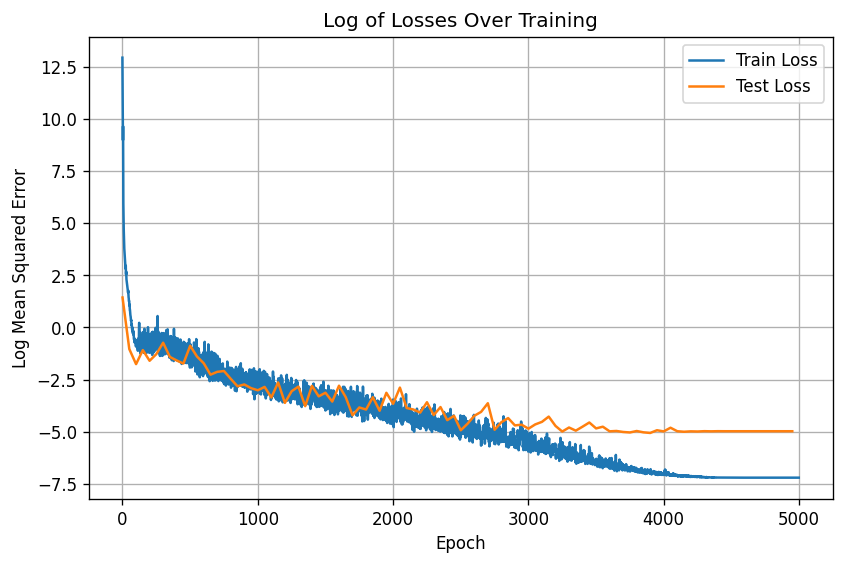

In [ ]:
# We only have test losses for every 50th epoch, so we create a new x-axis for it
test_epochs = np.arange(1, num_epochs + 1, 50)

plt.figure(figsize=(8, 5), dpi=120)
plt.plot(np.log(train_losses), label='Train Loss')
plt.plot(test_epochs, np.log(test_losses), label='Test Loss')
plt.title('Log of Losses Over Training')
plt.xlabel("Epoch")
plt.ylabel("Log Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

We can see the losses pretty steadily decrease over time, and level out at the end.

One way of measuring the actual accuracy of the model is to compare the Lagrangian over a single step. The following cell shows how the predicted $\ddot\theta$ and $\ddot{x}$ compare to the actual analytical solution at different points:

<ipython-input-30-149903609>:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 1, 1, 1])


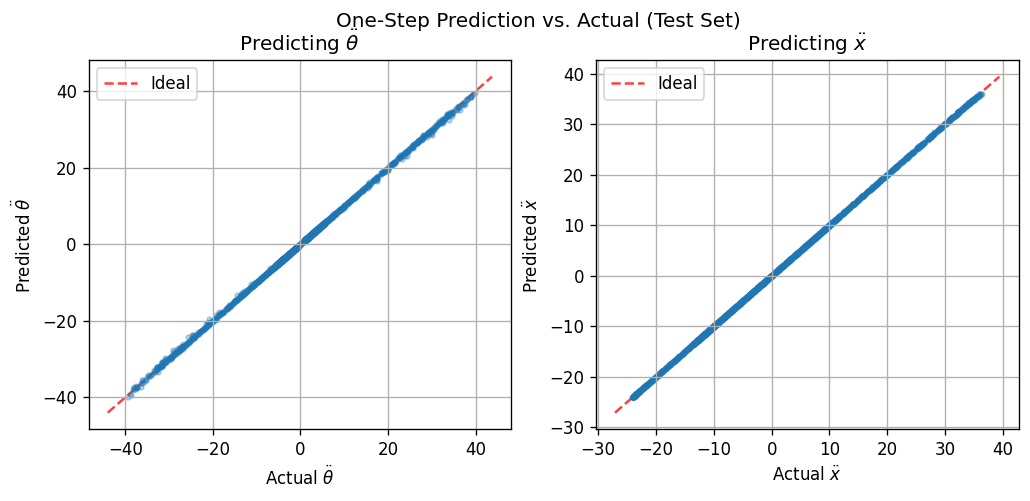

In [ ]:
# Create the final learned lagrangian function with the trained parameters
final_lagrangian = partial(learned_lagrangian_fn, final_params, mean_vec, scale_vec)

# Define the equation of motion for the final learned model
final_eom = partial(equation_of_motion, final_lagrangian)

# Get the LNN's predicted derivatives for the test set
xt_pred_lnn = jax.vmap(final_eom)(x_test)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
fig.suptitle('One-Step Prediction vs. Actual (Test Set)')

# Plot for theta_double_dot (index 2)
axes[0].scatter(xt_test[:, 2], xt_pred_lnn[:, 2], s=8, alpha=0.3)
axes[0].set_title('Predicting $\\ddot{\\theta}$')
axes[0].set_xlabel('Actual $\\ddot{\\theta}$')
axes[0].set_ylabel('Predicted $\\ddot{\\theta}$')
axes[0].grid(True)
# Add a 1:1 line for reference
lims = [min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]), max(axes[0].get_xlim()[1], axes[0].get_ylim()[1])]
axes[0].plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Ideal')
axes[0].legend()


# Plot for x_double_dot (index 3)
axes[1].scatter(xt_test[:, 3], xt_pred_lnn[:, 3], s=8, alpha=0.3)
axes[1].set_title('Predicting $\\ddot{x}$')
axes[1].set_xlabel('Actual $\\ddot{x}$')
axes[1].set_ylabel('Predicted $\\ddot{x}$')
axes[1].grid(True)
lims = [min(axes[1].get_xlim()[0], axes[1].get_ylim()[0]), max(axes[1].get_xlim()[1], axes[1].get_ylim()[1])]
axes[1].plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Ideal')
axes[1].legend()


plt.tight_layout(rect=[1, 1, 1, 1])
plt.show()

The linear trend of this scatter plot means this is considerably accurate. To better visualize this, let's compare the learned Lagrangian's simulation against the analytical solution for $\theta$ and $x$ over time on a full rollout:

Simulating LNN rollout...
Done.


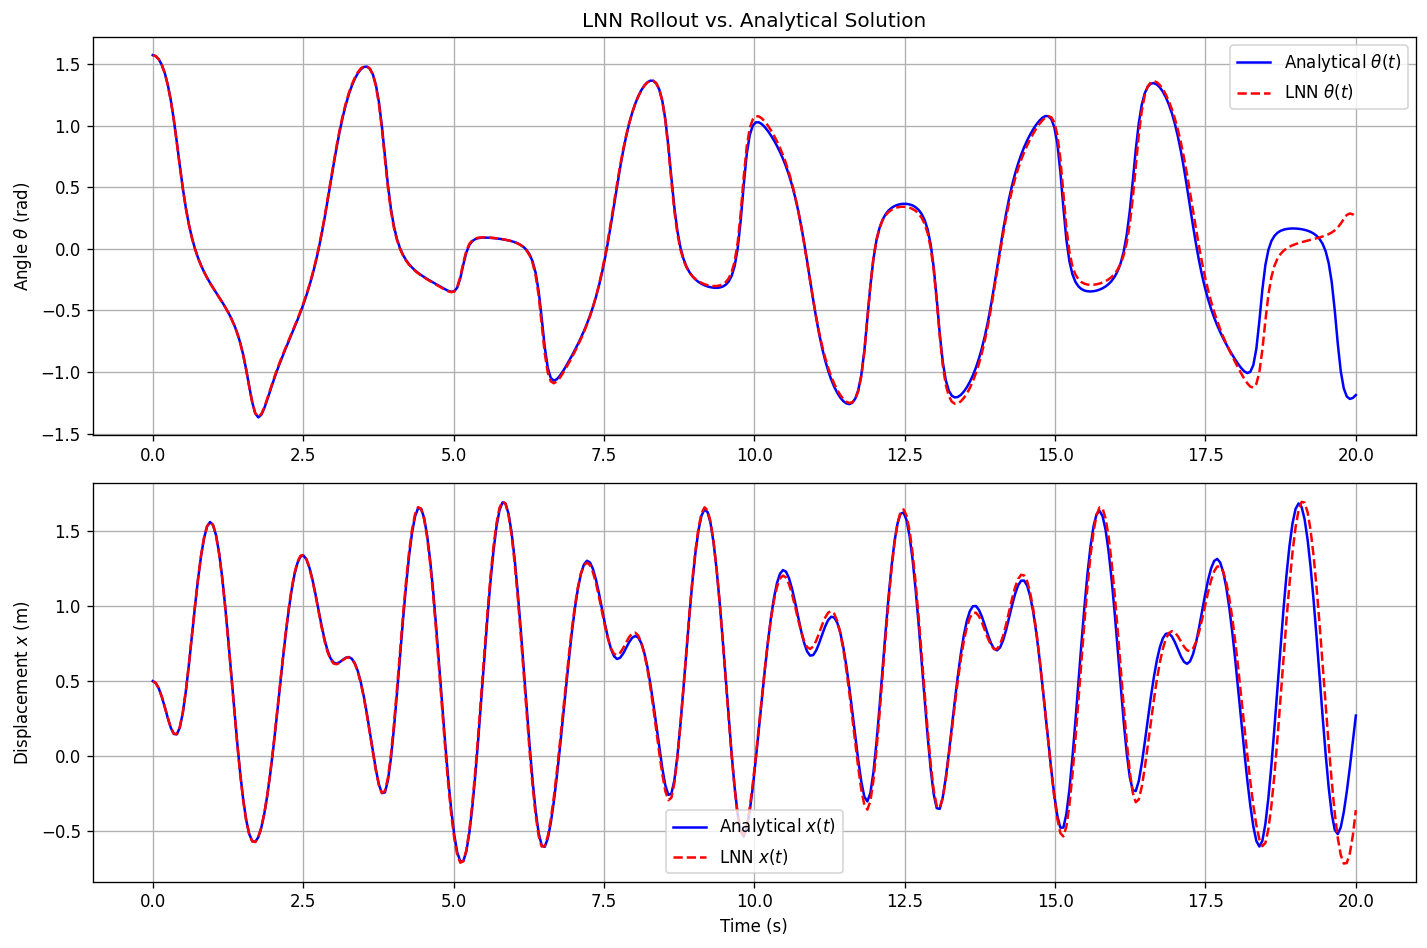

In [ ]:
# --- Simulate a long-term trajectory (rollout) ---

# Use the same initial state and time as your data generation
t_sim = np.linspace(0, 20, num=400, dtype=np.float32)
x0_sim = np.array([np.pi * 0.5, 0.5, 0.0, 0.0], dtype=np.float32)

# Get the trajectory from the analytical solver
x_analytical_sim = jax.device_get(solve_analytical(x0_sim, t_sim, m=m_val, l=l_val, g=g_val, k=k_val))

# Get the trajectory from the LNN solver
print("Simulating LNN rollout...")
x_lnn_sim = solve_lagrangian(final_lagrangian, x0_sim, t=t_sim, rtol=1e-6, atol=1e-6)
print("Done.")


# --- Plot the comparison ---
plt.figure(figsize=(12, 8), dpi=120)

# Plot theta
plt.subplot(2, 1, 1)
plt.plot(t_sim, x_analytical_sim[:, 0], 'b-', label='Analytical $\\theta(t)$')
plt.plot(t_sim, x_lnn_sim[:, 0], 'r--', label='LNN $\\theta(t)$')
plt.title('LNN Rollout vs. Analytical Solution')
plt.ylabel('Angle $\\theta$ (rad)')
plt.legend()
plt.grid(True)

# Plot x
plt.subplot(2, 1, 2)
plt.plot(t_sim, x_analytical_sim[:, 1], 'b-', label='Analytical $x(t)$')
plt.plot(t_sim, x_lnn_sim[:, 1], 'r--', label='LNN $x(t)$')
plt.ylabel('Displacement $x$ (m)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We can see from these plots that they stay on the same trajectory for a considerable amount of time. My model at the time of writing this only starts to visibly diverge at around $t=10$ (which is really ~200 time steps) or so, and even still remains decently on track.

The following code animates these trajectories. Note it may take a bit to animate:

In [ ]:
# --- Animation Code (Corrected) ---
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Function to get Cartesian coordinates from state (theta, x)
def get_cartesian_coords(state, l):
    theta, x = state[0], state[1]
    r = l + x # Total length of the spring
    # Origin is at (0, 0)
    y = -r * jnp.cos(theta) # y-coordinate (down is negative for plotting)
    x_coord = r * jnp.sin(theta) # x-coordinate
    return x_coord, y

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
# Adjust limits based on the maximum extension in the analytical simulation
ax_lim = l_val + jnp.max(jnp.abs(x_analytical_sim[:, 1])) + 0.5
ax.set_xlim(-ax_lim, ax_lim)
ax.set_ylim(-ax_lim, ax_lim)
ax.set_aspect('equal', adjustable='box')
ax.set_title("LNN Rollout vs. Analytical Solution")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)

# Draw the pivot point
ax.plot(0, 0, 'ko', markersize=5, zorder=5)

# Initialize the line and point for the analytical simulation
line_analytical, = ax.plot([], [], 'b-', lw=2, label='Analytical')
mass_analytical, = ax.plot([], [], 'bo', markersize=8)

# Initialize the line and point for the LNN simulation
# UPDATE: Changed label from 'Autograd' to 'LNN'
line_lnn, = ax.plot([], [], 'r--', lw=2, label='LNN')
mass_lnn, = ax.plot([], [], 'ro', markersize=6)

ax.legend(loc='upper right')

# Function to initialize the animation
def init():
    line_analytical.set_data([], [])
    mass_analytical.set_data([], [])
    line_lnn.set_data([], [])
    mass_lnn.set_data([], [])
    return (line_analytical, mass_analytical,
            line_lnn, mass_lnn)

# Function to update the plot for each frame
def animate(i):
    # Analytical state at time step i
    state_analytical_i = x_analytical_sim[i, :]
    x_an, y_an = get_cartesian_coords(state_analytical_i, l_val)
    line_analytical.set_data([0, x_an], [0, y_an])
    mass_analytical.set_data([x_an], [y_an])

    # LNN state at time step i
    state_lnn_i = x_lnn_sim[i, :]
    x_lnn, y_lnn = get_cartesian_coords(state_lnn_i, l_val)
    line_lnn.set_data([0, x_lnn], [0, y_lnn])
    mass_lnn.set_data([x_lnn], [y_lnn])

    # Return all artists that were updated
    return (line_analytical, mass_analytical,
            line_lnn, mass_lnn)


# Create the animation
# UPDATE: Calculated time step and multiplied by 1000 for milliseconds
time_step_s = t_sim[1] - t_sim[0]
interval_ms = time_step_s * 1000

ani = FuncAnimation(fig, animate, frames=len(t_sim), init_func=init, blit=True, interval=interval_ms)

# Close the figure to prevent it from showing as a static plot
plt.close(fig)

# Display the animation
display(HTML(ani.to_jshtml()))

Finally, let's generate some colorscale plots to compare our learned Lagrangian versus the analytical solution:

Generating data for colorscale plots...
Calculation complete.


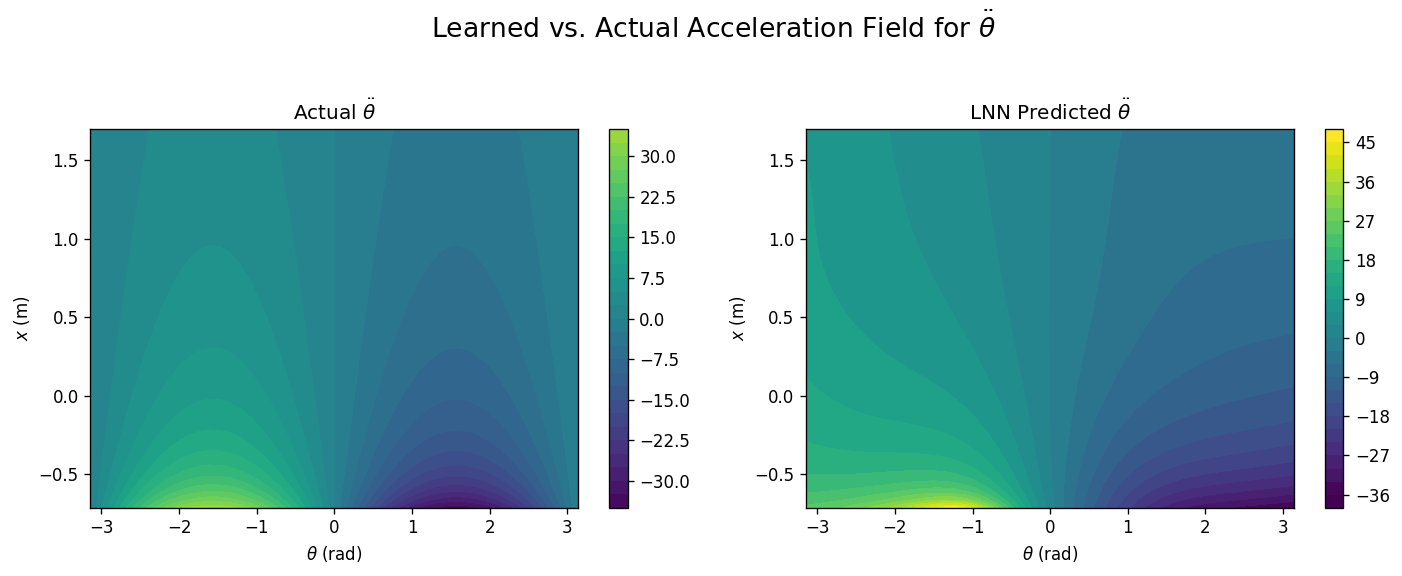

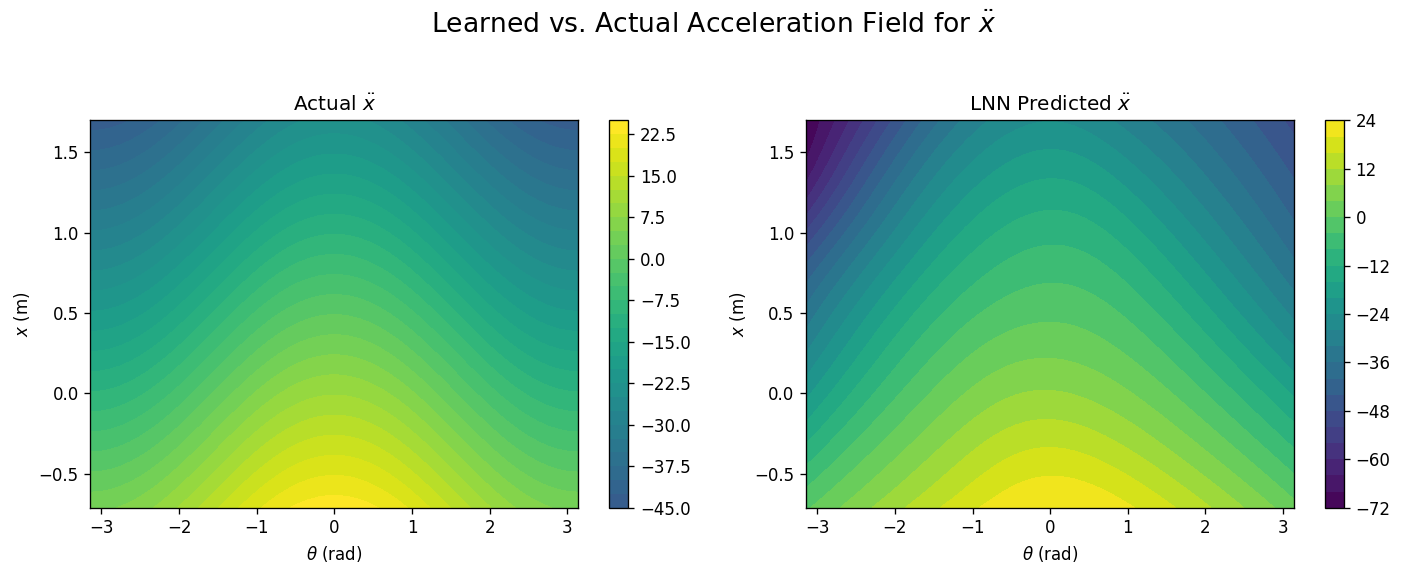

In [ ]:
# --- Colorscale Plot Generation ---
print("Generating data for colorscale plots...")

# 1. Create a grid of states
grid_size = 50
# Create a range for theta from -pi to pi
theta_range = jnp.linspace(-jnp.pi, jnp.pi, grid_size)
# Create a range for x based on the training data range
x_min, x_max = jnp.min(x_train[:, 1]), jnp.max(x_train[:, 1])
x_range = jnp.linspace(x_min, x_max, grid_size)

# Create the meshgrid
theta_grid, x_grid = jnp.meshgrid(theta_range, x_range)
# Create zero velocity grids
theta_t_grid = jnp.zeros_like(theta_grid)
x_t_grid = jnp.zeros_like(x_grid)

# Stack the grids to create a batch of states (grid_size*grid_size, 4)
scanned_states = jnp.stack([theta_grid, x_grid, theta_t_grid, x_t_grid], axis=-1).reshape(-1, 4)

# 2. Calculate actual and predicted accelerations
# Use the partial analytical function from data generation
xt_actual_grid = jax.vmap(f_analytical_partial)(scanned_states)

# Use the final trained LNN equation of motion
xt_predicted_grid = jax.vmap(final_eom)(scanned_states)
print("Calculation complete.")

# 3. Reshape data for plotting
# Reshape from (grid_size*grid_size, 4) to (grid_size, grid_size, 4)
actual_reshaped = xt_actual_grid.reshape(grid_size, grid_size, 4)
predicted_reshaped = xt_predicted_grid.reshape(grid_size, grid_size, 4)

# --- Plot the comparison ---

# Compare accelerations for theta
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)
fig.suptitle('Learned vs. Actual Acceleration Field for $\\ddot{\\theta}$', fontsize=16)

# Determine common color limits for a fair comparison
theta_dot_dot_min = min(jnp.min(actual_reshaped[:, :, 2]), jnp.min(predicted_reshaped[:, :, 2]))
theta_dot_dot_max = max(jnp.max(actual_reshaped[:, :, 2]), jnp.max(predicted_reshaped[:, :, 2]))

# Plot Actual theta_dot_dot
contour1 = axes[0].contourf(theta_grid, x_grid, actual_reshaped[:, :, 2], levels=30, vmin=theta_dot_dot_min, vmax=theta_dot_dot_max, cmap='viridis')
axes[0].set_title('Actual $\\ddot{\\theta}$')
axes[0].set_xlabel('$\\theta$ (rad)')
axes[0].set_ylabel('$x$ (m)')
fig.colorbar(contour1, ax=axes[0])

# Plot Predicted theta_dot_dot
contour2 = axes[1].contourf(theta_grid, x_grid, predicted_reshaped[:, :, 2], levels=30, vmin=theta_dot_dot_min, vmax=theta_dot_dot_max, cmap='viridis')
axes[1].set_title('LNN Predicted $\\ddot{\\theta}$')
axes[1].set_xlabel('$\\theta$ (rad)')
axes[1].set_ylabel('$x$ (m)')
fig.colorbar(contour2, ax=axes[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Compare accelerations for x
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)
fig.suptitle('Learned vs. Actual Acceleration Field for $\\ddot{x}$', fontsize=16)

# Determine common color limits
x_dot_dot_min = min(jnp.min(actual_reshaped[:, :, 3]), jnp.min(predicted_reshaped[:, :, 3]))
x_dot_dot_max = max(jnp.max(actual_reshaped[:, :, 3]), jnp.max(predicted_reshaped[:, :, 3]))

# Plot Actual x_dot_dot
contour1 = axes[0].contourf(theta_grid, x_grid, actual_reshaped[:, :, 3], levels=30, vmin=x_dot_dot_min, vmax=x_dot_dot_max, cmap='viridis')
axes[0].set_title('Actual $\\ddot{x}$')
axes[0].set_xlabel('$\\theta$ (rad)')
axes[0].set_ylabel('$x$ (m)')
fig.colorbar(contour1, ax=axes[0])

# Plot Predicted x_dot_dot
contour2 = axes[1].contourf(theta_grid, x_grid, predicted_reshaped[:, :, 3], levels=30, vmin=x_dot_dot_min, vmax=x_dot_dot_max, cmap='viridis')
axes[1].set_title('LNN Predicted $\\ddot{x}$')
axes[1].set_xlabel('$\\theta$ (rad)')
axes[1].set_ylabel('$x$ (m)')
fig.colorbar(contour2, ax=axes[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These look decently similar, with both acceleration fields following the same general color patterns. The most notable difference are in the extremes, as the LNN consistently predicts peaks and valleys considerable more extreme in magnitude than the actual solution. Additionally, the difference in direction/shape of contour lines in the $\ddot\theta$ graph (top). Instead of the left and right halves of the plot following arc shapes (as in the actual solution), the predicted acceleration contour lines continue out to the edges of the plot. I am unsure of the implications of this, but found it interesting. Also, if your model gets different data, that's cool too. [Email it to me.](mailto:choconnor@ucsd.edu)

Next, let's analyze the energy conservation of the system:

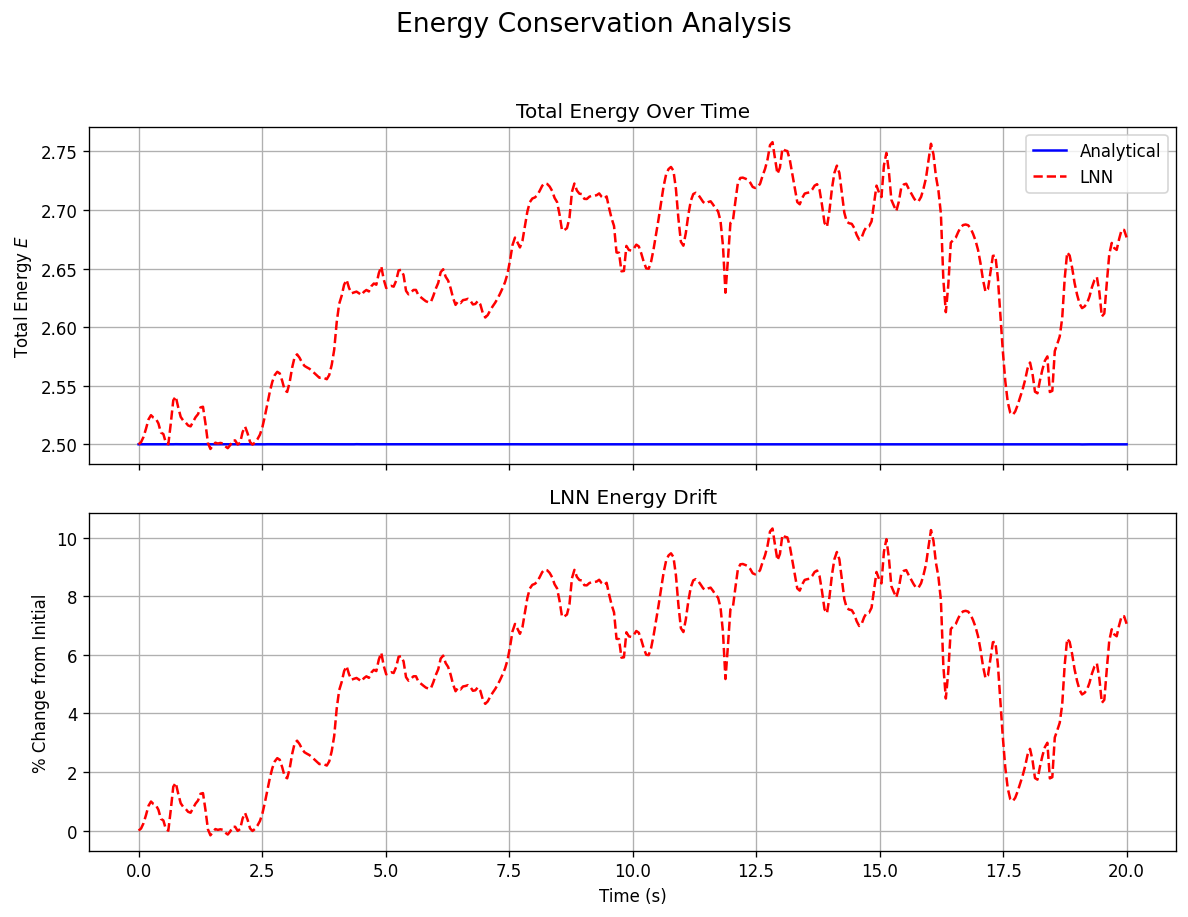

In [ ]:
# --- Energy Conservation Analysis ---

# 1. Define the Total Energy function E = T + V
# Based on the components from your analytical_lagrangian function
def total_energy(state, m, l, g, k):
    """Calculates the total energy of the spring pendulum system."""
    q, q_t = jnp.split(state, 2)
    theta, x = q
    theta_t, x_t = q_t

    # Kinetic Energy (T)
    T = 0.5 * m * (x_t**2 + (l + x)**2 * theta_t**2)
    # Potential Energy (V)
    V = 0.5 * k * x**2 - m * g * (l + x) * jnp.cos(theta)

    return T + V

# Create a version of the energy function with our system parameters baked in
energy_func = partial(total_energy, m=m_val, l=l_val, g=g_val, k=k_val)

# 2. Calculate energy over time for both trajectories
# Use jax.vmap to efficiently apply the function over the whole trajectory
energy_analytical = jax.vmap(energy_func)(x_analytical_sim)
energy_lnn = jax.vmap(energy_func)(x_lnn_sim)


# 3. Plot the results
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=120, sharex=True)
fig.suptitle('Energy Conservation Analysis', fontsize=16)

# Plot the absolute energy over time
axes[0].plot(t_sim, energy_analytical, 'b-', label='Analytical')
axes[0].plot(t_sim, energy_lnn, 'r--', label='LNN')
axes[0].set_ylabel('Total Energy $E$')
axes[0].set_title('Total Energy Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the percentage change in energy for the LNN model
initial_energy_lnn = energy_lnn[0]
energy_change_lnn = 100 * (energy_lnn - initial_energy_lnn) / initial_energy_lnn

axes[1].plot(t_sim, energy_change_lnn, 'r--')
axes[1].set_ylabel('% Change from Initial')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('LNN Energy Drift')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Note that this shows there is, in fact, energy drift. Now before you pull out your pitchforks, please consider that a 10% increase in total energy isn't really *that* much...

Okay, I'll prove it. Let's compare it to a standard multilayer perceptron model.

## "Naïve" Standard Neural Network

The following code implements a standard multilayer perceptron, essentially following the same structure as our LNN from earlier, but using a standard loss function instead of solving the Lagrangian like the LNN.

Please allow for another 5-10 minutes for this model to run:

In [ ]:
# --- 1. Define the Standard MLP Model ---
class MLP_Dynamics(nn.Module):
    """A standard MLP to directly learn the system's dynamics."""
    hidden_dim: int
    output_dim: int = 4 # The output is the 4D state derivative

    @nn.compact
    def __call__(self, x):
        """Forward pass of the network."""
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(features=self.output_dim)(x)
        return x

# --- 2. Setup the Training Process ---

# We use the same hyperparameters for a fair comparison
learning_rate = 1e-3
hidden_dim = 128
num_epochs = 5000
batch_size = 256
clip_threshold = 1.0

# Initialize the MLP model
mlp_model = MLP_Dynamics(hidden_dim=hidden_dim)
key = random.PRNGKey(42) # Use a different key for different initial weights
# Note: The input is the scaled state
scaled_x_train = (x_train - mean_vec) / scale_vec
params = mlp_model.init(key, scaled_x_train[0])['params']

# Setup the optimizer (same as before)
optimizer = optax.chain(
    optax.clip_by_global_norm(clip_threshold),
    optax.adam(learning_rate=learning_rate) # A simpler constant LR is fine here
)

# Create a new TrainState for the MLP
mlp_state = train_state.TrainState.create(
    apply_fn=mlp_model.apply,
    params=params,
    tx=optimizer
)

# --- Define a new, simpler Loss Function ---
@jax.jit
def mlp_loss_fn(params, state_batch, target_batch):
    # The MLP directly predicts the derivatives.
    # We must scale the input state before passing it to the model.
    scaled_state_batch = (state_batch - mean_vec) / scale_vec
    predicted_derivatives = mlp_model.apply({'params': params}, scaled_state_batch)
    return jnp.mean((predicted_derivatives - target_batch)**2)

# --- Define new Training and Eval Steps ---
@jax.jit
def mlp_train_step(state, state_batch, target_batch):
    loss, grads = jax.value_and_grad(mlp_loss_fn)(state.params, state_batch, target_batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def mlp_eval_step(params, state_batch, target_batch):
    loss = mlp_loss_fn(params, state_batch, target_batch)
    return loss

# --- 3. Run the MLP Training Loop ---
mlp_train_losses = []
mlp_test_losses = []
rng = random.PRNGKey(0)

print("Starting training for the standard MLP baseline...")
for epoch in range(num_epochs):
    rng, perm_key = random.split(rng)
    perm = random.permutation(perm_key, len(x_train))
    shuffled_x_train, shuffled_xt_train = x_train[perm], xt_train[perm]

    for i in range(0, len(x_train), batch_size):
        x_batch = shuffled_x_train[i:i+batch_size]
        xt_batch = shuffled_xt_train[i:i+batch_size]
        mlp_state, loss = mlp_train_step(mlp_state, x_batch, xt_batch)

    if (epoch + 1) % 50 == 0:
        train_loss = mlp_eval_step(mlp_state.params, x_train, xt_train)
        test_loss = mlp_eval_step(mlp_state.params, x_test, xt_test)
        mlp_train_losses.append(train_loss)
        mlp_test_losses.append(test_loss)
        print(f"Epoch {epoch+1:4d}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

print("MLP training finished.")
final_mlp_params = mlp_state.params

Starting training for the standard MLP baseline...
Epoch   50/5000 | Train Loss: 0.845908 | Test Loss: 0.742951
Epoch  100/5000 | Train Loss: 0.136335 | Test Loss: 0.130532
Epoch  150/5000 | Train Loss: 0.047165 | Test Loss: 0.053418
Epoch  200/5000 | Train Loss: 0.029928 | Test Loss: 0.035719
Epoch  250/5000 | Train Loss: 0.019306 | Test Loss: 0.023906
Epoch  300/5000 | Train Loss: 0.016910 | Test Loss: 0.019261
Epoch  350/5000 | Train Loss: 0.014304 | Test Loss: 0.018238
Epoch  400/5000 | Train Loss: 0.008351 | Test Loss: 0.011771
Epoch  450/5000 | Train Loss: 0.014467 | Test Loss: 0.018064
Epoch  500/5000 | Train Loss: 0.010179 | Test Loss: 0.014197
Epoch  550/5000 | Train Loss: 0.008583 | Test Loss: 0.010572
Epoch  600/5000 | Train Loss: 0.008405 | Test Loss: 0.010369
Epoch  650/5000 | Train Loss: 0.012374 | Test Loss: 0.016308
Epoch  700/5000 | Train Loss: 0.011424 | Test Loss: 0.014530
Epoch  750/5000 | Train Loss: 0.005844 | Test Loss: 0.008854
Epoch  800/5000 | Train Loss: 0.01

Even though it may seem like this trains much faster and gets to a very low loss (Train Loss: 0.000520 and Test Loss: 0.003594 for me), let's compare this model's energy conservation to the actual analytical solution as well as our LNN:

Simulating MLP rollout...
Done.


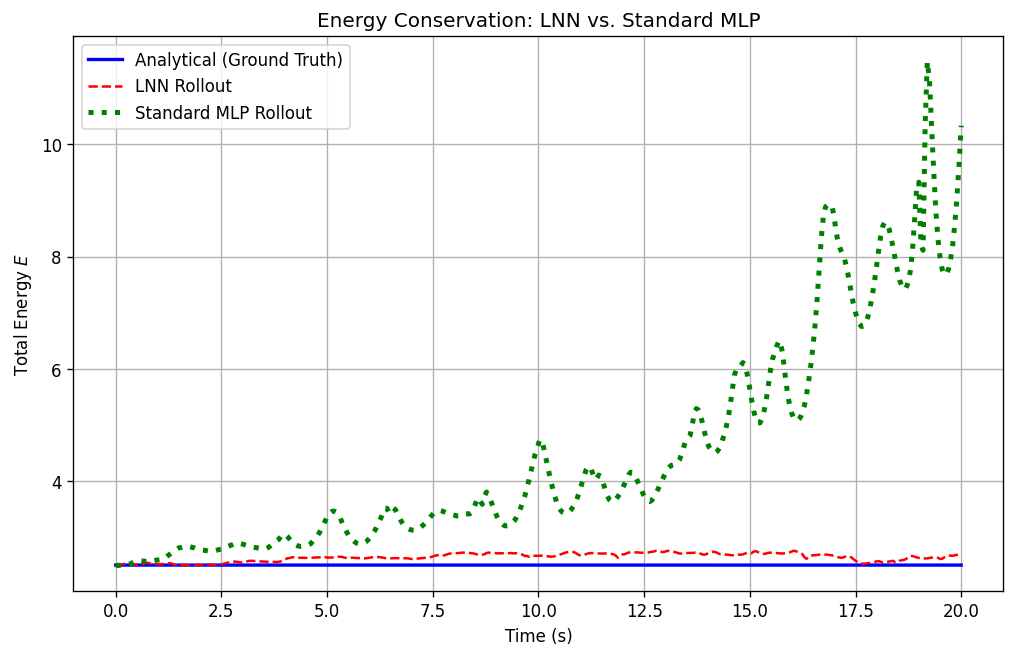

In [ ]:
# --- 4. Analyze the MLP's Energy Conservation ---

# Define the dynamics function for the MLP, for use in the ODE solver
def mlp_dynamics_func(state, t, params):
    # This function takes an unscaled state, scales it,
    # gets the prediction from the MLP, and returns it.
    scaled_state = (state - mean_vec) / scale_vec
    return mlp_model.apply({'params': params}, scaled_state)

# Create a partial function with the final trained MLP parameters
final_mlp_dynamics = partial(mlp_dynamics_func, params=final_mlp_params)

# Simulate the MLP rollout
print("Simulating MLP rollout...")
x_mlp_sim = odeint(final_mlp_dynamics, x0_sim, t_sim, rtol=1e-6, atol=1e-6)
print("Done.")

# Calculate the total energy of the MLP's trajectory
energy_mlp = jax.vmap(energy_func)(x_mlp_sim)

# --- Plot the definitive comparison ---
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(t_sim, energy_analytical, 'b-', label='Analytical (Ground Truth)', linewidth=2)
plt.plot(t_sim, energy_lnn, 'r--', label='LNN Rollout')
plt.plot(t_sim, energy_mlp, 'g:', label='Standard MLP Rollout', linewidth=3)

plt.title('Energy Conservation: LNN vs. Standard MLP')
plt.xlabel('Time (s)')
plt.ylabel('Total Energy $E$')
plt.legend()
plt.grid(True)
plt.show()

*A-ha!* The Standard MLP explodes in energy much faster and to a much greater degree than the LNN. This shows how the LNN is much better at conserving energy than the standard neural network model.

Let's see their differences in trajectory via rollout animation and trajectory plots:

In [ ]:
# --- 3-Way Comparison Animation Code ---
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Function to get Cartesian coordinates from state (theta, x)
def get_cartesian_coords(state, l):
    theta, x = state[0], state[1]
    r = l + x # Total length of the spring
    y = -r * jnp.cos(theta) # y-coordinate
    x_coord = r * jnp.sin(theta) # x-coordinate
    return x_coord, y

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
# Adjust limits based on the maximum extension in the analytical simulation
ax_lim = l_val + jnp.max(jnp.abs(x_analytical_sim[:, 1])) + 0.5
ax.set_xlim(-ax_lim, ax_lim)
ax.set_ylim(-ax_lim, ax_lim)
ax.set_aspect('equal', adjustable='box')
ax.set_title("LNN vs. MLP vs. Analytical Solution")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)

# Draw the pivot point
ax.plot(0, 0, 'ko', markersize=5, zorder=5)

# Initialize artists for the Analytical simulation (blue, solid)
line_analytical, = ax.plot([], [], 'b-', lw=2.5, label='Analytical')
mass_analytical, = ax.plot([], [], 'bo', markersize=10)

# Initialize artists for the LNN simulation (red, dashed)
line_lnn, = ax.plot([], [], 'r--', lw=2, label='LNN')
mass_lnn, = ax.plot([], [], 'ro', markersize=7)

# Initialize artists for the MLP simulation (green, dotted)
line_mlp, = ax.plot([], [], 'g:', lw=2, label='Standard MLP')
mass_mlp, = ax.plot([], [], 'go', markersize=7)


ax.legend(loc='upper right')

# Function to initialize the animation
def init():
    line_analytical.set_data([], [])
    mass_analytical.set_data([], [])
    line_lnn.set_data([], [])
    mass_lnn.set_data([], [])
    line_mlp.set_data([], [])
    mass_mlp.set_data([], [])
    return (line_analytical, mass_analytical,
            line_lnn, mass_lnn,
            line_mlp, mass_mlp)

# Function to update the plot for each frame
def animate(i):
    # Analytical state
    state_an = x_analytical_sim[i, :]
    x_an, y_an = get_cartesian_coords(state_an, l_val)
    line_analytical.set_data([0, x_an], [0, y_an])
    mass_analytical.set_data([x_an], [y_an])

    # LNN state
    state_lnn = x_lnn_sim[i, :]
    x_lnn, y_lnn = get_cartesian_coords(state_lnn, l_val)
    line_lnn.set_data([0, x_lnn], [0, y_lnn])
    mass_lnn.set_data([x_lnn], [y_lnn])

    # MLP state
    state_mlp = x_mlp_sim[i, :]
    x_mlp, y_mlp = get_cartesian_coords(state_mlp, l_val)
    line_mlp.set_data([0, x_mlp], [0, y_mlp])
    mass_mlp.set_data([x_mlp], [y_mlp])

    return (line_analytical, mass_analytical,
            line_lnn, mass_lnn,
            line_mlp, mass_mlp)


# Create the animation
time_step_s = t_sim[1] - t_sim[0]
interval_ms = time_step_s * 1000

# To make the animation faster, you can animate every N frames using a frame step
frame_step = 1 # Animate every 5th frame
frames_to_render = len(t_sim) // frame_step

ani = FuncAnimation(fig,
                    lambda i: animate(i * frame_step), # Animate with the frame step
                    frames=frames_to_render,
                    init_func=init,
                    blit=True,
                    interval=interval_ms * frame_step)

# Close the figure to prevent it from showing as a static plot
plt.close(fig)

# Display the animation
display(HTML(ani.to_jshtml()))

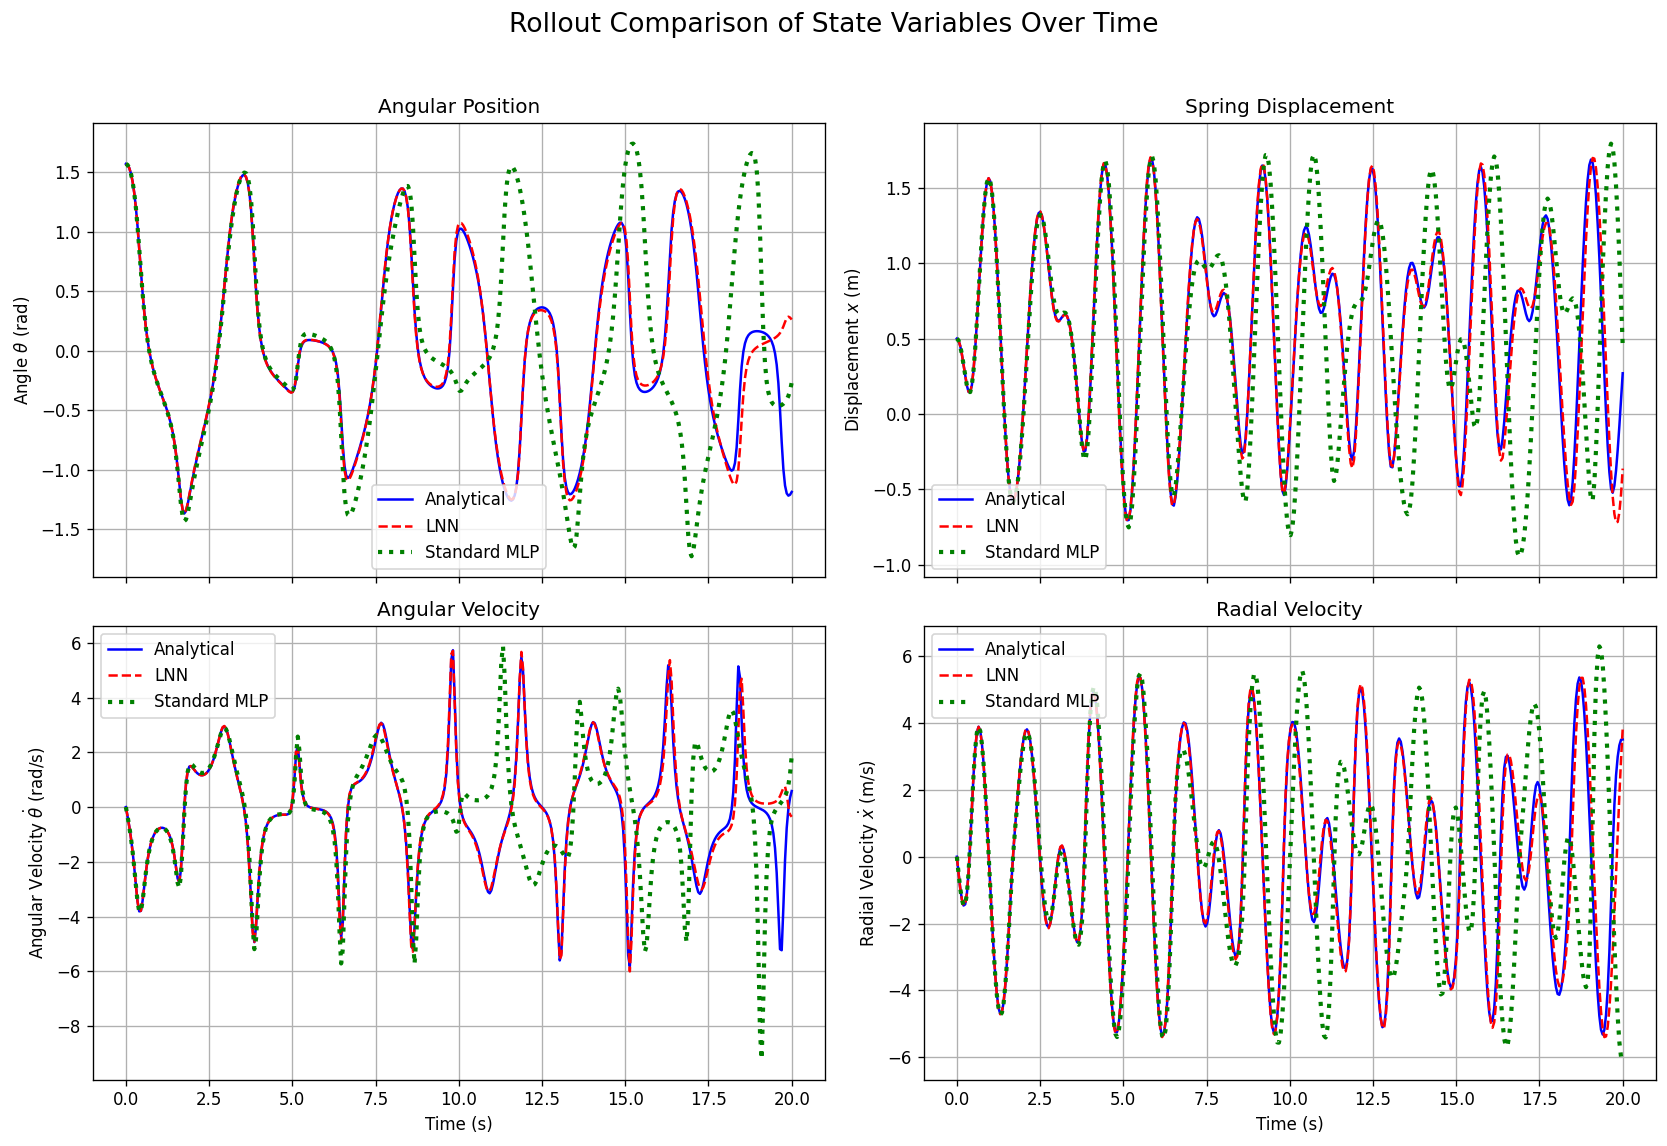

In [ ]:
# --- Rollout Trajectory Comparison Plots ---

# Create a 2x2 grid of subplots
# sharex=True aligns the time axis for all plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=120, sharex=True)
fig.suptitle('Rollout Comparison of State Variables Over Time', fontsize=16)

# Plot styles
analytical_style = {'color': 'b', 'linestyle': '-', 'label': 'Analytical'}
lnn_style = {'color': 'r', 'linestyle': '--', 'label': 'LNN'}
mlp_style = {'color': 'g', 'linestyle': ':', 'label': 'Standard MLP', 'linewidth': 2.5}

# --- Subplot 1: Angular Position (theta) ---
axes[0, 0].plot(t_sim, x_analytical_sim[:, 0], **analytical_style)
axes[0, 0].plot(t_sim, x_lnn_sim[:, 0], **lnn_style)
axes[0, 0].plot(t_sim, x_mlp_sim[:, 0], **mlp_style)
axes[0, 0].set_ylabel('Angle $\\theta$ (rad)')
axes[0, 0].set_title('Angular Position')
axes[0, 0].grid(True)
axes[0, 0].legend()

# --- Subplot 2: Spring Displacement (x) ---
axes[0, 1].plot(t_sim, x_analytical_sim[:, 1], **analytical_style)
axes[0, 1].plot(t_sim, x_lnn_sim[:, 1], **lnn_style)
axes[0, 1].plot(t_sim, x_mlp_sim[:, 1], **mlp_style)
axes[0, 1].set_ylabel('Displacement $x$ (m)')
axes[0, 1].set_title('Spring Displacement')
axes[0, 1].grid(True)
axes[0, 1].legend()

# --- Subplot 3: Angular Velocity (theta_dot) ---
axes[1, 0].plot(t_sim, x_analytical_sim[:, 2], **analytical_style)
axes[1, 0].plot(t_sim, x_lnn_sim[:, 2], **lnn_style)
axes[1, 0].plot(t_sim, x_mlp_sim[:, 2], **mlp_style)
axes[1, 0].set_ylabel('Angular Velocity $\\dot{\\theta}$ (rad/s)')
axes[1, 0].set_title('Angular Velocity')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# --- Subplot 4: Radial Velocity (x_dot) ---
axes[1, 1].plot(t_sim, x_analytical_sim[:, 3], **analytical_style)
axes[1, 1].plot(t_sim, x_lnn_sim[:, 3], **lnn_style)
axes[1, 1].plot(t_sim, x_mlp_sim[:, 3], **mlp_style)
axes[1, 1].set_ylabel('Radial Velocity $\\dot{x}$ (m/s)')
axes[1, 1].set_title('Radial Velocity')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].grid(True)
axes[1, 1].legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Notably from the plots, it seems the Standard MLP most struggles with the angular position and velocity, with the radial displacement and velocity a bit closer to the actual solution. But obviously, they both fall apart after some time.

This animation and these plots show how much more accurate the LNN is at predicting the trajectory and rollout of the elastic pendulum than the standard MLP model, even though they were given the same amount of data and training time.

## Conclusion

In conclusion, Lagrangian Neural Networks are most beneficial when trying to determine the Lagrangian dynamics of a system when the momenta are unknown or nontrivial to solve for. Compared to Standard Multilayer Perceptrons, they create much more accurate models and are much better at conserving energy. This Notebook illustrated this relationship using an elastic pendulum system, and accounted for errors such as using JAX's automatic differentiation function.

Thank you for reading! In the future, I would like to do more explorations on the applications of machine learning principles in physics, especially when it comes to accurately and efficiently modeling complex systems, discovering new physics, and generally making cool things and simulations.